In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-beta1


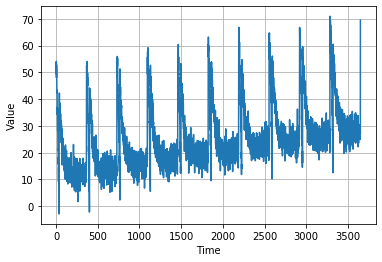

In [2]:
def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope = 0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude = 1, phase = 0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype = "float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)
# Update with noise
series += noise(time, noise_level, seed = 42)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis = -1), input_shape = [None]), # YOUR CODE HERE
    # YOUR CODE HERE
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x:x * 10.0) # YOUR CODE HERE
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])
history = model.fit(dataset, epochs = 100, callbacks = [lr_schedule])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
94/94 [==============================] - 13s 133ms/step - loss: 20.6804 - mae: 21.0336
Epoch 2/100
94/94 [==============================] - 4s 43ms/step - loss: 20.6504 - mae: 21.0052
Epoch 3/100
94/94 [==============================] - 4s 44ms/step - loss: 20.6179 - mae: 20.9728
Epoch 4/100
94/94 [==============================] - 4s 42ms/step - loss: 20.5813 - mae: 20.9362
Epoch 5/100
94/94 [==============================] - 4s 48ms/step - loss: 20.5397 - mae: 20.8947: 1s - loss: 19.6454 -
Epoch 6/100
94/94 [==============================] - 4s 41ms/step - loss: 20.4926 - mae: 20.8476
Epoch 7/100
94/94 [==============================] - 5s 54ms/step - loss: 20.4390 - mae: 20.7941
Epoch 8/100
94/94 [==============================] - 4s 44ms/step - loss: 20.3783 - mae: 20.7334
Epoch 9/100
94/94 [==============================] - 4s 46ms/step - loss: 20.3100 - mae: 20.6651
Epoch 10/

94/94 [==============================] - 4s 43ms/step - loss: 19.4606 - mae: 19.8163
Epoch 19/100
94/94 [==============================] - 4s 45ms/step - loss: 19.3142 - mae: 19.6700
Epoch 20/100
94/94 [==============================] - 4s 39ms/step - loss: 19.1502 - mae: 19.5061
Epoch 21/100
94/94 [==============================] - 4s 38ms/step - loss: 18.9663 - mae: 19.3222
Epoch 22/100
94/94 [==============================] - 4s 39ms/step - loss: 18.7596 - mae: 19.1156
Epoch 23/100
94/94 [==============================] - 4s 38ms/step - loss: 18.5270 - mae: 18.8829
Epoch 24/100
94/94 [==============================] - 4s 44ms/step - loss: 18.2645 - mae: 18.6203
Epoch 25/100
94/94 [==============================] - 5s 54ms/step - loss: 17.9678 - mae: 18.3238
Epoch 26/100
94/94 [==============================] - 5s 51ms/step - loss: 17.6323 - mae: 17.9882
Epoch 27/100
94/94 [==============================] - 5s 53ms/step - loss: 17.2541 - mae: 17.6101
Epoch 28/100
94/94 [=============

[1e-08, 0.0001, 0, 30]

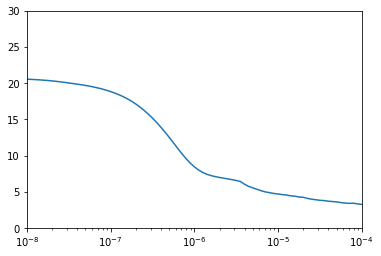

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# FROM THIS PICK A LEARNING RATE

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x:tf.expand_dims(x, axis = -1), input_shape = [None]), # YOUR CODE HERE
    # YOUR CODE HERE
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x:x * 100.0) # YOUR CODE HERE
])

model.compile(loss = "mse", optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9),metrics = ["mae"])
history = model.fit(dataset,epochs = 500,verbose = 1)
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3

Epoch 1/500
94/94 [==============================] - 11s 117ms/step - loss: 304.9686 - mae: 10.2188
Epoch 2/500
94/94 [==============================] - 4s 41ms/step - loss: 48.1486 - mae: 4.6277
Epoch 3/500
94/94 [==============================] - 3s 37ms/step - loss: 43.0006 - mae: 4.3898
Epoch 4/500
94/94 [==============================] - 3s 37ms/step - loss: 40.6683 - mae: 4.2536
Epoch 5/500
94/94 [==============================] - 3s 37ms/step - loss: 38.3222 - mae: 4.1023
Epoch 6/500
94/94 [==============================] - 4s 38ms/step - loss: 37.1147 - mae: 4.0193
Epoch 7/500
94/94 [==============================] - 3s 36ms/step - loss: 36.3061 - mae: 3.9628
Epoch 8/500
94/94 [==============================] - 3s 37ms/step - loss: 35.6179 - mae: 3.9129
Epoch 9/500
94/94 [==============================] - 3s 37ms/step - loss: 34.9316 - mae: 3.8644
Epoch 10/500
94/94 [==============================] - 3s 35ms/step - loss: 34.3196 - mae: 3.8214
Epoch 11/500
94/94 [===============

94/94 [==============================] - 3s 37ms/step - loss: 33.1873 - mae: 3.7136
Epoch 23/500
94/94 [==============================] - 3s 36ms/step - loss: 32.9795 - mae: 3.6994
Epoch 24/500
94/94 [==============================] - 3s 36ms/step - loss: 32.7374 - mae: 3.6844
Epoch 25/500
94/94 [==============================] - 3s 36ms/step - loss: 32.3408 - mae: 3.6597
Epoch 26/500
94/94 [==============================] - 3s 36ms/step - loss: 32.5902 - mae: 3.6768
Epoch 27/500
94/94 [==============================] - 3s 36ms/step - loss: 31.9122 - mae: 3.6358
Epoch 28/500
94/94 [==============================] - 3s 36ms/step - loss: 31.9698 - mae: 3.6492
Epoch 29/500
94/94 [==============================] - 3s 37ms/step - loss: 31.3457 - mae: 3.6026 0s - loss: 27.
Epoch 30/500
94/94 [==============================] - 4s 37ms/step - loss: 31.2847 - mae: 3.6065
Epoch 31/500
94/94 [==============================] - 4s 38ms/step - loss: 30.7777 - mae: 3.5636
Epoch 32/500
94/94 [========

94/94 [==============================] - 4s 41ms/step - loss: 27.7770 - mae: 3.3215
Epoch 107/500
94/94 [==============================] - 4s 38ms/step - loss: 27.7465 - mae: 3.3186
Epoch 108/500
94/94 [==============================] - 3s 37ms/step - loss: 27.7505 - mae: 3.3201
Epoch 109/500
94/94 [==============================] - 4s 38ms/step - loss: 27.7258 - mae: 3.3168
Epoch 110/500
94/94 [==============================] - 3s 37ms/step - loss: 27.7199 - mae: 3.3175
Epoch 111/500
94/94 [==============================] - 3s 36ms/step - loss: 27.6980 - mae: 3.3145
Epoch 112/500
94/94 [==============================] - 3s 36ms/step - loss: 27.6876 - mae: 3.3147
Epoch 113/500
94/94 [==============================] - 3s 37ms/step - loss: 27.6693 - mae: 3.3122
Epoch 114/500
94/94 [==============================] - 3s 36ms/step - loss: 27.6540 - mae: 3.3117
Epoch 115/500
94/94 [==============================] - 3s 37ms/step - loss: 27.6382 - mae: 3.3095
Epoch 116/500
94/94 [=============

94/94 [==============================] - 4s 42ms/step - loss: 26.5695 - mae: 3.2127
Epoch 190/500
94/94 [==============================] - 4s 39ms/step - loss: 26.5661 - mae: 3.2119
Epoch 191/500
94/94 [==============================] - 4s 41ms/step - loss: 26.5476 - mae: 3.2109
Epoch 192/500
94/94 [==============================] - 4s 40ms/step - loss: 26.5468 - mae: 3.2102
Epoch 193/500
94/94 [==============================] - 4s 40ms/step - loss: 26.5262 - mae: 3.2089
Epoch 194/500
94/94 [==============================] - 4s 40ms/step - loss: 26.5181 - mae: 3.2077
Epoch 195/500
94/94 [==============================] - 3s 37ms/step - loss: 26.5044 - mae: 3.2068
Epoch 196/500
94/94 [==============================] - 4s 38ms/step - loss: 26.5036 - mae: 3.2063
Epoch 197/500
94/94 [==============================] - 4s 38ms/step - loss: 26.4835 - mae: 3.2050
Epoch 198/500
94/94 [==============================] - 3s 37ms/step - loss: 26.4752 - mae: 3.2038
Epoch 199/500
94/94 [=============

94/94 [==============================] - 5s 58ms/step - loss: 25.8221 - mae: 3.1455
Epoch 273/500
94/94 [==============================] - 5s 54ms/step - loss: 25.8074 - mae: 3.1448
Epoch 274/500
94/94 [==============================] - 5s 54ms/step - loss: 25.8117 - mae: 3.1447
Epoch 275/500
94/94 [==============================] - 5s 55ms/step - loss: 25.7925 - mae: 3.1436
Epoch 276/500
94/94 [==============================] - 6s 59ms/step - loss: 25.7917 - mae: 3.1430
Epoch 277/500
94/94 [==============================] - 5s 53ms/step - loss: 25.7786 - mae: 3.1423
Epoch 278/500
94/94 [==============================] - 5s 54ms/step - loss: 25.7837 - mae: 3.1424
Epoch 279/500
94/94 [==============================] - 5s 55ms/step - loss: 25.7638 - mae: 3.1412
Epoch 280/500
94/94 [==============================] - 5s 54ms/step - loss: 25.7631 - mae: 3.1407
Epoch 281/500
94/94 [==============================] - 5s 54ms/step - loss: 25.7502 - mae: 3.1400
Epoch 282/500
94/94 [=============

94/94 [==============================] - 5s 52ms/step - loss: 25.3175 - mae: 3.1050
Epoch 356/500
94/94 [==============================] - 5s 50ms/step - loss: 25.3225 - mae: 3.1052
Epoch 357/500
94/94 [==============================] - 5s 55ms/step - loss: 25.3081 - mae: 3.1043
Epoch 358/500
94/94 [==============================] - 5s 50ms/step - loss: 25.3130 - mae: 3.1045
Epoch 359/500
94/94 [==============================] - 5s 50ms/step - loss: 25.2987 - mae: 3.1036
Epoch 360/500
94/94 [==============================] - 5s 50ms/step - loss: 25.3036 - mae: 3.1038
Epoch 361/500
94/94 [==============================] - 5s 50ms/step - loss: 25.2894 - mae: 3.1029
Epoch 362/500
94/94 [==============================] - 5s 50ms/step - loss: 25.2944 - mae: 3.1031
Epoch 363/500
94/94 [==============================] - 5s 51ms/step - loss: 25.2803 - mae: 3.1022
Epoch 364/500
94/94 [==============================] - 5s 52ms/step - loss: 25.2852 - mae: 3.1024
Epoch 365/500
94/94 [=============

94/94 [==============================] - 5s 52ms/step - loss: 24.9991 - mae: 3.0806
Epoch 439/500
94/94 [==============================] - 5s 51ms/step - loss: 24.9900 - mae: 3.0796
Epoch 440/500
94/94 [==============================] - 5s 51ms/step - loss: 24.9925 - mae: 3.0801
Epoch 441/500
94/94 [==============================] - 5s 51ms/step - loss: 24.9835 - mae: 3.0791
Epoch 442/500
94/94 [==============================] - 5s 49ms/step - loss: 24.9861 - mae: 3.0796
Epoch 443/500
94/94 [==============================] - 5s 53ms/step - loss: 24.9770 - mae: 3.0786
Epoch 444/500
94/94 [==============================] - 5s 51ms/step - loss: 24.9796 - mae: 3.0791
Epoch 445/500
94/94 [==============================] - 5s 50ms/step - loss: 24.9706 - mae: 3.0781
Epoch 446/500
94/94 [==============================] - 5s 54ms/step - loss: 24.9733 - mae: 3.0786
Epoch 447/500
94/94 [==============================] - 5s 52ms/step - loss: 24.9643 - mae: 3.0776
Epoch 448/500
94/94 [=============

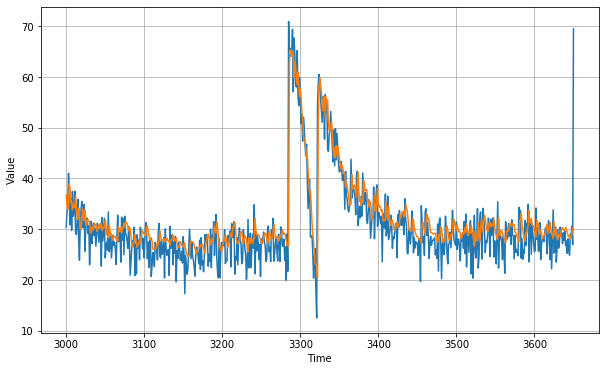

In [7]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

3.2721443

<Figure size 432x288 with 0 Axes>

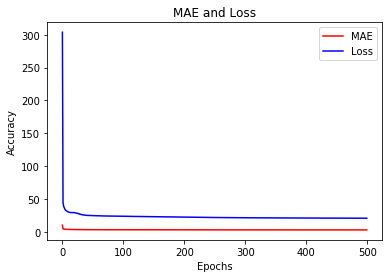

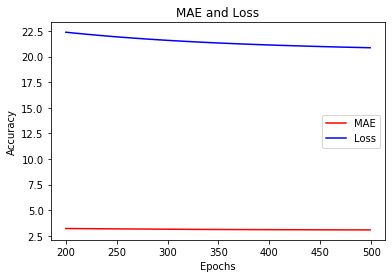

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae = history.history["mae"]
loss = history.history["loss"]

epochs = range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, "r")
plt.plot(epochs, loss, "b")
plt.title("MAE and Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, "r")
plt.plot(epochs_zoom, loss_zoom, "b")
plt.title("MAE and Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()